# Poisson Regression

In [159]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from IPython.display import Image

## Count data

Poisson models are suited for forecasting count data. 

Characteristics of count date:
* **Non-negative Integers:** OLS works best with real numbers (-635, -3, 4, 200) 
* **Skewed distribution:** Large number of data points for just a few values
* **Sparsity:** The data might have many zeros
* **Rate of occurance:** There is a certain rate of occurence of events $\lambda$ which may drift over time

A good strategy is to start off with a Poisson Regression and use it as a benchmark for other models.

## Poisson Process

* **Sequence of random variables:** $X_1, X_2, X_k$ each variable represents a number of occurances of some event ie. sales
* **Stochastic process:** each run will produces a different sequence of random outcomes as per some probability distribution
* **Discreet process:** number of occurences in some specified time period, which is undoublty integer
* **Independednt increments:** the number of occurances in a given time period or independent of any number of occurences in any other period
* **Identical distribution:** all $X_1, X_2, X_k$ originate from the same Poisson distribution

  
    
    
**PDF: Probability of occurences in a unit of time**

$
P_{x}(k) = \frac{\exp(-\lambda )*(\lambda )^k}{k!}
$


**PDF: Probability of occurences in t units of time**

$
P_{x}(k) = \frac{\exp(-\lambda t)*(\lambda t)^k}{k!}
$

**$P_{x}(k)$:** probability of occurance  
**$k$:** number of events  
**$\lambda$:** average occurance of events per unit time  
**$t$:** units of time

#### Probability Mass Function of occurences in a unit of time for various $\lambda$

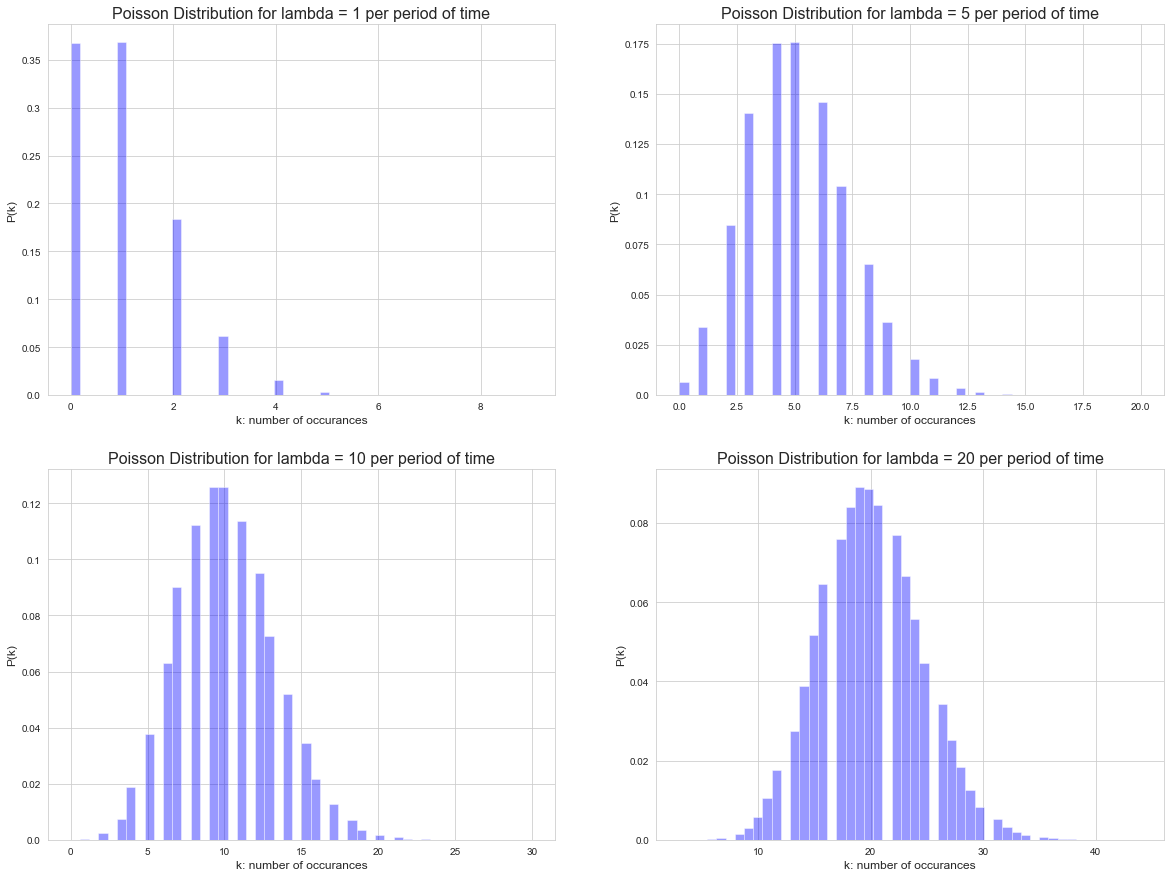

In [2]:
sample_size = 1000000

fig = plt.figure(figsize=(20,15))


for i, mu in enumerate([1, 5, 10, 20]):
    poisson = np.random.poisson(lam=mu, size=sample_size)
    
    ax = fig.add_subplot(2,2,i+1)
    sns.distplot(poisson, kde=False, ax=ax, color='Blue')
    ax.set_title(
        f"Poisson Distribution for lambda = {mu} per period of time",
        fontsize=16
    )
    ax.set_ylabel("P(k)", fontsize=12)
    ax.set_xlabel("k: number of occurances", fontsize=12)
    yticklabels = [int(i)/sample_size for i in ax.get_yticks()]
    ax.set_yticklabels(yticklabels)

#### Probability Mass Function of occurences in t units of time for $\lambda=20$

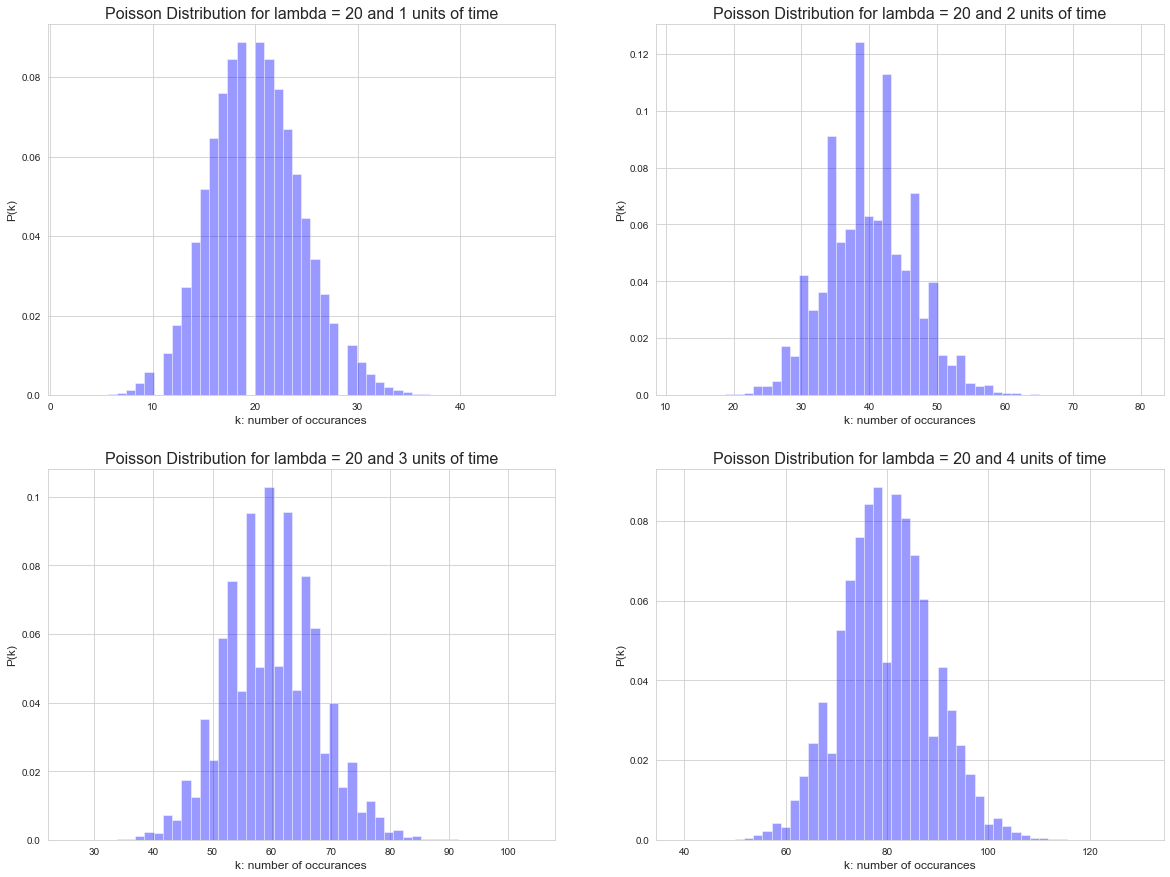

In [3]:
sample_size = 10000000
mu = 20

fig = plt.figure(figsize=(20,15))


for i, t in enumerate([1, 2, 3, 4]):
    poisson = np.random.poisson(lam=mu*t, size=sample_size)
    
    ax = fig.add_subplot(2,2,i+1)
    sns.distplot(poisson, kde=False, ax=ax, color='Blue')
    ax.set_title(
        f"Poisson Distribution for lambda = 20 and {t} units of time",
        fontsize=16
    )
    ax.set_ylabel("P(k)", fontsize=12)
    ax.set_xlabel("k: number of occurances", fontsize=12)
    yticklabels = [int(i)/sample_size for i in ax.get_yticks()]
    ax.set_yticklabels(yticklabels)

#### Modelling inter-arrival times of a Poisson Process

Even though the number of occurence of evetns can be modeled using a discrete Poisson distribution, the interval between consecutive events can be modeled using an Exponential distribution.
  
Let $X1, X2, X3,..$ be random variables such that:  

$X1$: interval of time between start of process and first arrival  
$X2$: interval of time between first arrival and second arrival  
...

**PDF: Probability of inter-arrival t $(k-1)$ and $k$ arrival**  

$
P_{x}(t) = \lambda*\exp(-\lambda t)
$

**CDF: Probability of inter-arrival t $(k-1)$ and $k$ arrival is less than or equal to some value t**  

$
P_{x}(X<=t) = \int_0^t \lambda*\exp(-\lambda t) = 1 - \exp(-\lambda t)
$

**The above CDF $F_x$ allows us to generate inter-arrival times in a Poisson process. The algorithm we follow is Inverse Transform sampling for continuous distributions.**

1. Generate $U$~$Unif(0,1)$
2. Let $X = F^-1_x(U)$

**Inverse function fo the CDF of inter-arrival times is:**   
  
$
F^-1_x(t)=-\frac{\ln(1-t)}{\lambda}
$

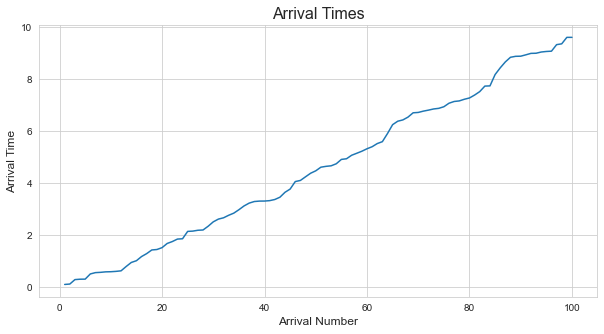

In [4]:
number_arrivals = 100
poisson_lambda = 10
arrival_time = 0
arrival_number = 0
arrival_times = []
arrivals = []

for i in range(number_arrivals):
    #Generate probability from Uniform(0,1)
    p = np.random.random()
    
    #Generate inter-arrival t from inverse of CDF of the Exponential(possion_lambda)
    inter_arrival_time = -np.log(1.0-p)/ poisson_lambda
    
    #Add inter_arrival_time to running sum of arrival time
    arrival_time += inter_arrival_time
    arrival_times.append(arrival_time)
    arrival_number += 1
    arrivals.append(arrival_number)
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

sns.lineplot(x=arrivals, y=arrival_times, ax=ax)
ax.set_title('Arrival Times', fontsize=16)
ax.set_xlabel('Arrival Number', fontsize=12)
ax.set_ylabel('Arrival Time', fontsize=12)

plt.show()

## Regression Strategy

A sound practice is to start with Poisson regression model and use it a benchmark for more complex models, less constrained models.

### Poisson Regression Model Specification

$\lambda$ is influence by a vector of explanatory variables. We call this matrix of regression variables, $X$.  

The job of the Poisson Regression model is to fit the observed counts $y$ to the regrsssion matrix $X$ via a link-function that express the rate vector $\lambda$ as a funtion of (1) the regression coefficients $\beta$ and (2) the regression matrix $X$.

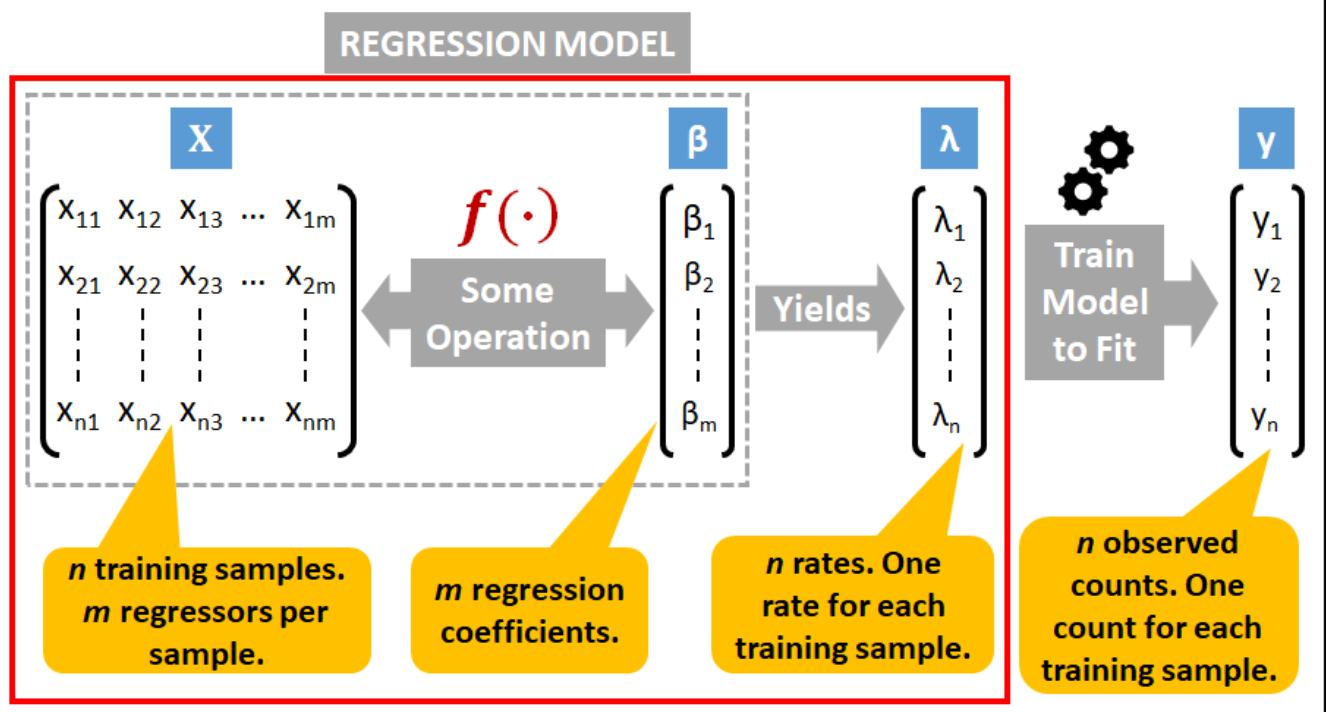

In [5]:
Image(filename="../resources/images/poisson_regression.png", width=700)

### What is missing is a function $f$ connecting $\lambda$ with $X$? It turns out the following link-function works great:

$\lambda_i = \exp(X_i \beta)$

* keeps $\lambda$ non-negative even when $X$ ot $\beta$ is negative


### Formal specification 

For the ith observation in the dataset the denoted by $y_i$ corresponding to the row of regression variabble $x_i$, the probability of observing the count $y_i$ is Poissson distrbuted as per the following PMF

$PMF(y_i|X_i)=\frac{\exp(-\lambda_i) *\lambda_i^{y_i}}{y_i!}$
  
where $\lambda_i = \exp(X_i \beta)$

### At prediction time
  
$y_p = \lambda_p = \exp(X_p \beta)$

### Training using MLE

The technique for identifying the coefficients $\beta$ is called Maxium Likelihood Estiamtion MLE.

Assume the below dataset

In [6]:
dataset = pd.DataFrame({
    "x1": [78.1, 73.0],
    "x2": [0.0, 0.01],
    "count": [3468, 3271]   
})

dataset

,x1,x2,count
0,78.1,0.00,3468
1,73.0,0.01,3271


**Our assumption by design is that count follows a Poisson process. Hence, probabbilities of occurances is given by the poisson PMF.**

$P(3468|X)=\frac{\exp(-\lambda_0) *\lambda_0^{3468}}{3468!}$, where $\lambda_0 = \exp(X[0] \beta)$  
  
$P(3271|X)=\frac{\exp(-\lambda_1) *\lambda_1^{3271}}{3271!}$, where $\lambda_1 = \exp(X[1] \beta)$   
  

**The proability of occurence of the entire set of the 4 counts in the training set is the join probability of occurence of the individual counts. Due to the assumption of the Poisson distribution they are indepedent from one another and thus can be expressed as a simple multiplication.**

$P(y|X)=P(3468|X)*P(3271|X)$

**The likelihood function for $\beta$ is the above after we plug in the individual count probabilities**

$L(\beta)=\frac{\exp(-\lambda_0) *\lambda_0^{3468}}{3468!}*\frac{\exp(-\lambda_1) *\lambda_1^{3271}}{3271!}$  
   
**Remember that:** $\lambda_i = \exp(X_i \beta)$

**What value of $\beta$ will make the given set of observed counts $y$ more likely? Its the value that maximises the likelihood function. Thus we will take the derivative of likelihood fucntion wrt $\beta$ and set it to zero. Its easier to differentiate the logarithm of the likelihood function thus we get:**

$\ln(L(\beta))=\ln(\frac{\exp(-\lambda_0) *\lambda_0^{3468}}{3468!}*\frac{\exp(-\lambda_1) *\lambda_1^{3271}}{3271!})$
  
$\ln(L(\beta)) = ln(\frac{\exp(-\lambda_0) *\lambda_0^{3468}}{3468!})+\ln(\frac{\exp(-\lambda_1) *\lambda_1^{3271}}{3271!})$
    
$\ln(L(\beta))=\ln(\exp(-\lambda_0) *\lambda_0^{3468}) - \ln(3468!)+\ln(\exp(-\lambda_1) *\lambda_1^{3271}) - \ln(3271!)$
  
$\ln(L(\beta))=\ln(\exp(-\lambda_0)) + ln(\lambda_0^{3468}) - \ln(3468!)+\ln(\exp(-\lambda_1)) + \ln(\lambda_1^{3271}) - \ln(3271!)$
  
$\ln(L(\beta))=-\lambda_0 + ln(\lambda_0^{3468}) - \ln(3468!)-\lambda_1 + \ln(\lambda_1^{3271}) - \ln(3271!)$
  
$\ln(L(\beta)) = \sum_{i=1}^{n}( -\lambda_i+ ln(\lambda_i^{y_i}) - \ln{y_i!})$
  
$\ln(L(\beta)) = \sum_{i=1}^{n}( -\exp(X_i \beta)+ ln(\exp(X_i \beta)^{y_i}) - \ln{y_i!})$
  
$\ln(L(\beta)) = \sum_{i=1}^{n}( -\exp(X_i \beta)+ ln(\exp( y_i X_i \beta) - \ln{y_i!})$
   
$\ln(L(\beta)) = \sum_{i=1}^{n}(y_i X_i \beta -\exp(X_i \beta) - \ln{y_i!})$

$\frac{\partial \ln(L(\beta))}{\partial \beta}=\sum_{i=1}^{n}(y_i X_i -X_i\exp(X_i \beta) )$
  
$\frac{\partial \ln(L(\beta))}{\partial \beta}=\sum_{i=1}^{n}(y_i -\exp(X_i \beta))X_i$
  
$\frac{\partial \ln(L(\beta))}{\partial \beta}=0 \implies \sum_{i=1}^{n}(y_i -\exp(X_i \beta))X_i=0$

# Summary of steps for performing Poisson Regression

1. Dataset contains counts (non-negative integer values) that represent number of occurrences of some event during some interval.
2. Decide on regression varables that inluence observed counts
3. Carve out training data that the regression model will be trained on. Keep the test data aside.
4. Use Python statsmodel package to configure and fit the Poisson Regressoin model on the training data.
5. Test performance of model by running it on test data set so as to generate predicted counts. Compare them to test data set.
6. Use a goodness-of-fit measure to determine how well you model has trained on the training data set.

### Data cleansing and feature engineering

In [97]:
# read data from url into dataframe
url = "https://gist.githubusercontent.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv"
df = pd.read_csv(url)

# convert Date column from object to datetime64
df["Date"] = pd.to_datetime(df["Date"])

# create month, day_of_week and day features
df["MONTH"] = df["Date"].dt.month
df["DAYOFWEEK"] = df["Date"].dt.dayofweek
df["DAY"] = df["Date"].dt.day

# set date as index
df = df[["Date", "BB_COUNT", "MONTH","DAYOFWEEK", "DAY", "HIGH_T", "LOW_T", "PRECIP" ]]
df = df.rename(columns=({"Date": "DATE"}))
df = df.set_index("DATE")

df.head(5)

,BB_COUNT,MONTH,DAYOFWEEK,DAY,HIGH_T,LOW_T,PRECIP
DATE,,,,,,,
2017-04-01,606,4,5,1,46.0,37.0,0.00
2017-04-02,2021,4,6,2,62.1,41.0,0.00
2017-04-03,2470,4,0,3,63.0,50.0,0.03
2017-04-04,723,4,1,4,51.1,46.0,1.18
2017-04-05,2807,4,2,5,63.0,46.0,0.00


### Split train test

In [144]:
# using an alternative method from sklearn
mask =np.random.rand(len(df)) < 0.8

df_train = df[mask]
df_test = df[~mask]

print(f"Length of training dataset: {len(df_train)}")
print(f"Length of test dataset: {len(df_test)}")

# create regression expression in patsy notation
expr = """BB_COUNT ~ DAY + DAYOFWEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

# break df_train into y_train, X_train
y_train, X_train = dmatrices(expr, df_train, return_type="dataframe")

# break df_test into y_test, X_test
y_test, X_test = dmatrices(expr, df_test, return_type="dataframe")

Length of training dataset: 172
Length of test dataset: 42


### Train Poisson Regression Model using statsmodel

In [123]:
poisson = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  165
Model:                            GLM   Df Residuals:                      158
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10922.
Date:                Sat, 13 Feb 2021   Deviance:                       20256.
Time:                        21:25:17   Pearson chi2:                 2.01e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0738      0.012    568.670      0.0

### Evaluate on test dataset

Mean absolute percentage error is: 23.0%


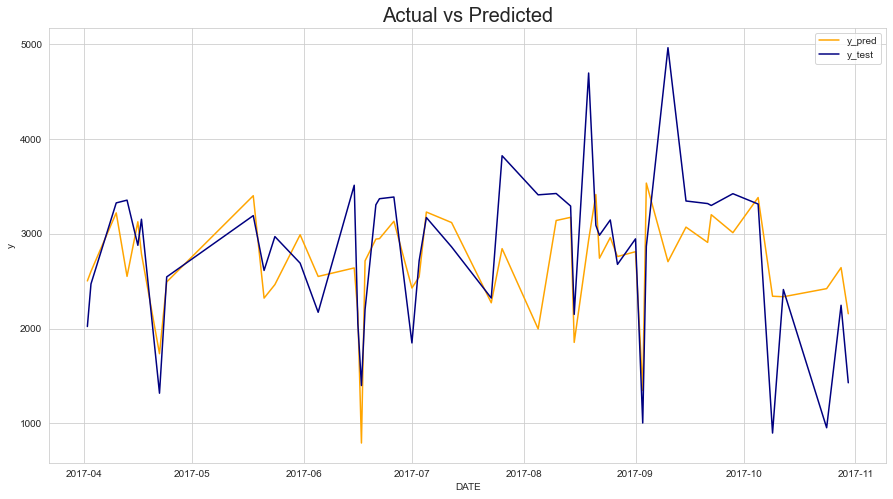

In [166]:
y_pred = poisson.get_prediction(X_test)
y_pred = y_pred.summary_frame()["mean"]


evalutation_df = pred_df.join(test_df)
evalutation_df.columns = ["y_pred", "y_test"]

evalutation_df

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

sns.lineplot(x=evalutation_df.index, y="y_pred", data=evalutation_df, color="orange", label="y_pred", ax=ax)
sns.lineplot(x=evalutation_df.index, y="y_test", data=evalutation_df, color="navy", label="y_test", ax=ax)

ax.set_title("Actual vs Predicted", fontsize=20)
ax.set_ylabel("y")

mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean absolute percentage error is: {np.round(mape, 2)*100}%")

plt.show()